In [36]:
import os
#os.chdir("../../")
os.getcwd()

'/Users/cory/Desktop/Lectures/notebooks/nlp'

# A. Data

In [37]:
with open("data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

## 1. Tokenizer example 

- We use a pre-built tokenizer in the previous notebook: [NLP-Basics-2-Transformers.ipynb: 3.1.2](NLP-Basics-2-Transformers.ipynb)

- Example from: Raschka, Sebastian. Build A Large Language Model (From Scratch). Manning, 2024. ISBN: 978-1633437166.
    - https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/ch02.ipynb

In [38]:
import re
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [39]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)
vocab = {token:integer for integer,token in enumerate(all_words)}


1130


In [40]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text
    
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


# 2. Attention example

- Derived from: Raschka, Sebastian. Build A Large Language Model (From Scratch). Manning, 2024. ISBN: 978-1633437166.
    - https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/ch03.ipynb



**Multi-Head Attention for GPT**

This code demonstrates the core attention mechanism used in transformer models:

1. **Token & Position Embeddings**: Converts text tokens into dense vectors and adds positional information so the model understands word order

2. **Multi-Head Attention**: The key innovation that allows the model to focus on different parts of the input simultaneously through multiple attention heads. Uses causal masking to prevent looking at future tokens (essential for next-token prediction)

3. **Visualization**: Dynamically plots attention weights for any number of heads, showing which tokens the model focuses on when processing each position

**Important Note**: This is an educational demonstration isolating *only* the attention mechanism. A complete GPT model would include additional layers:
- Layer Normalization (before/after attention)
- Feed-Forward Networks (MLP layers after attention)
- Residual connections (skip connections)
- Multiple transformer blocks (stacking attention + FFN repeatedly)
- Final output projection (to vocabulary size)

Simply change `num_heads` variable to visualize different numbers of attention heads (1, 2, 4, 8, etc.).

In [41]:
import tiktoken
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
        self.heads = nn.ModuleList([SingleHead(d_in, self.head_dim, context_length, dropout, qkv_bias, 
                                                self.W_query, self.W_key, self.W_value, i) 
                                    for i in range(num_heads)])

    def forward(self, x):
        b, n_tokens, d_in = x.shape
        
        queries = self.W_query(x).view(b, n_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = self.W_key(x).view(b, n_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = self.W_value(x).view(b, n_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores.masked_fill_(self.mask.bool()[:n_tokens, :n_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / self.head_dim**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = (attn_weights @ values).transpose(1, 2).contiguous().view(b, n_tokens, self.d_out)
        return self.out_proj(context_vec)


class SingleHead(nn.Module):
    def __init__(self, d_in, head_dim, context_length, dropout, qkv_bias, W_query, W_key, W_value, head_idx):
        super().__init__()
        self.head_idx = head_idx
        self.head_dim = head_dim
        self.W_query = W_query
        self.W_key = W_key
        self.W_value = W_value
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

In [42]:
with open("data/small-text-sample.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = tokenizer.encode(raw_text)

In [44]:
vocab_size = 50257
output_dim = 256
context_length = 1024
max_length = 4
num_heads = 2

x = torch.tensor(token_ids[:max_length]).unsqueeze(0)
token_embedding_layer = nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = nn.Embedding(context_length, output_dim)

token_embeddings = token_embedding_layer(x)
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
input_embeddings = token_embeddings + pos_embeddings

mha = MultiHeadAttention(d_in=output_dim, d_out=output_dim, context_length=context_length, dropout=0.1, num_heads=num_heads)

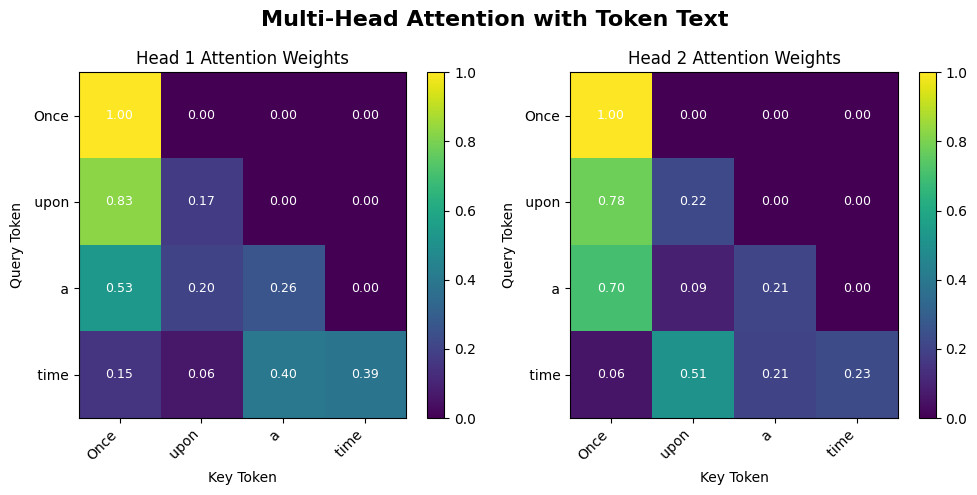


Batch Details:
Input tokens: [7454, 2402, 257, 640]
Decoded text: ['Once', ' upon', ' a', ' time']


In [45]:
def plot_attention_with_text(x, mha, tokenizer, token_embedding_layer, pos_embedding_layer):
    num_heads = mha.num_heads
    cols = min(num_heads, 4)
    rows = (num_heads + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    fig.suptitle('Multi-Head Attention with Token Text', fontsize=16, fontweight='bold')
    
    if num_heads == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if num_heads > 1 else [axes]
    
    with torch.no_grad():
        batch_idx = 0
        x_tokens = x[batch_idx]
        
        tokens_text = [tokenizer.decode([token_id.item()]) for token_id in x_tokens]
        
        token_embeddings = token_embedding_layer(x)
        pos_embeddings = pos_embedding_layer(torch.arange(x.shape[1]))
        input_embeddings = token_embeddings + pos_embeddings
        
        sample = input_embeddings[batch_idx:batch_idx+1]
        b, n_tokens, d_in = sample.shape
        
        attn_weights_list = []
        
        for head in mha.heads:
            queries = head.W_query(sample).view(b, n_tokens, mha.num_heads, mha.head_dim)[:, :, head.head_idx, :]
            keys = head.W_key(sample).view(b, n_tokens, mha.num_heads, mha.head_dim)[:, :, head.head_idx, :]
            
            attn_scores = queries @ keys.transpose(1, 2)
            attn_scores.masked_fill_(head.mask.bool()[:n_tokens, :n_tokens], -torch.inf)
            attn_weights = torch.softmax(attn_scores / mha.head_dim**0.5, dim=-1)
            attn_weights_list.append(attn_weights[0].numpy())
        
        for idx in range(num_heads):
            ax = axes[idx]
            im = ax.imshow(attn_weights_list[idx], cmap='viridis', aspect='auto')
            ax.set_title(f'Head {idx+1} Attention Weights')
            ax.set_xlabel('Key Token')
            ax.set_ylabel('Query Token')
            ax.set_xticks(range(len(tokens_text)))
            ax.set_yticks(range(len(tokens_text)))
            ax.set_xticklabels(tokens_text, rotation=45, ha='right')
            ax.set_yticklabels(tokens_text)
            
            for i in range(len(tokens_text)):
                for j in range(len(tokens_text)):
                    text = ax.text(j, i, f'{attn_weights_list[idx][i, j]:.2f}',
                                 ha="center", va="center", color="white", fontsize=9)
            
            plt.colorbar(im, ax=ax)
        
        for idx in range(num_heads, len(axes)):
            fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    print("\nBatch Details:")
    print(f"Input tokens: {x_tokens.tolist()}")
    print(f"Decoded text: {tokens_text}")
plot_attention_with_text(x, mha, tokenizer, token_embedding_layer, pos_embedding_layer)

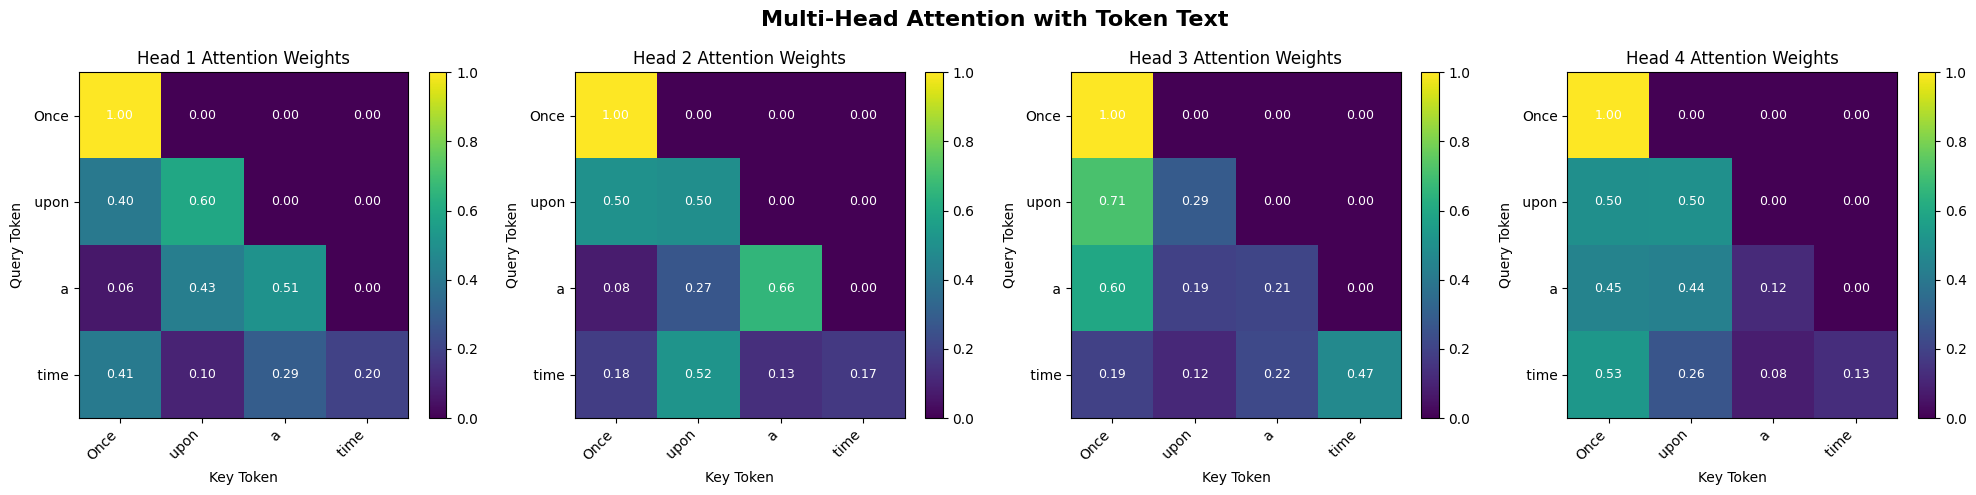


Batch Details:
Input tokens: [7454, 2402, 257, 640]
Decoded text: ['Once', ' upon', ' a', ' time']


In [46]:
num_heads = 4
mha = MultiHeadAttention(d_in=output_dim, d_out=output_dim, context_length=context_length, dropout=0.1, num_heads=num_heads)
plot_attention_with_text(x, mha, tokenizer, token_embedding_layer, pos_embedding_layer)


# 3. A Simple GPT-like Model Explained 🤖

This code builds a simple version of a "decoder-only" transformer, similar to the architecture of GPT-2. Its main goal is to **predict the next word in a sequence**.

Let's break down how it works, starting with the most important part.

## The "Brain": `TransformerBlock`

Think of the whole model as a stack of these `TransformerBlock`s. Each block is like a processing station. Its job is to take in a set of token embeddings (numeric representations of words) and make them "smarter" by adding context.

Each block does two main things, one after the other:

1.  **Attention (Tokens Talk):** First, it uses **Multi-Head Attention**. This is a fancy way of saying that every token in the sequence gets to "look at" and "talk to" all the *previous* tokens. This is how the model understands context. For example, in "The cat sat on the...", the word "on" can look back at "cat" and "sat" to figure out what's going on.
2.  **Feed-Forward (Tokens Think):** After "talking," each token needs to "think" about the new information it just gathered. It does this by passing through its own private `FeedForward` network (a small, simple 2-layer "brain").

This two-step process (talk, then think) repeats for every block in the stack.

**Two key tricks make this work:**

* **Residual Connections:** After both the "talk" and "think" steps, the code adds the *original input* back to the *output*. This is like writing a draft, getting feedback, and then adding that feedback to your original draft instead of starting over. It helps the model learn without "forgetting" what it started with.
* **Normalization (`LayerNorm`):** Before each "talk" or "think" step, the data is "cleaned up" using `LayerNorm`. This just keeps the numbers from getting too big or too small, which makes training the model much more stable.

---

## The Key Components

These are the modules used inside the `TransformerBlock`.

### `MultiHeadAttention`
This is the "talking" part.
* **Why "Multi-Head"?** Instead of having tokens "talk" just once, we split them into multiple "heads" (e.g., 12 heads). This is like having 12 different people look at the same sentence. One person might focus on grammar, another on the main subject, etc. The model then combines all these different "perspectives."
* **Causal Mask:** This is the most important part for a GPT. It's a "mask" that **prevents the model from cheating**. It ensures that when predicting the next word, a token can *only* look at tokens that came *before* it, not after.

### `FeedForward`
This is the "thinking" part. It's just a standard two-layer neural network that processes each token's information *independently*.

---

## The Full `GPTModel`

This class assembles everything into the final model:

1.  **Embedding:** The model can't read words, so it first converts token IDs (like `50257`) into **token embeddings** (rich vectors of numbers). It also adds **positional embeddings**, which are vectors that tell the model *where* each word is in the sequence (e.g., 1st word, 2nd word, etc.).
2.  **Transformer Blocks:** The combined embeddings are sent through the stack of `TransformerBlock`s (e.g., 12 blocks, one after another).
3.  **Final Prediction:** After the final block, a single linear layer (the `out_head`) takes the "smart" token vectors and converts them into **logits**. Logits are just raw scores for every single word in the model's vocabulary. The word with the highest score is the model's best guess for the next token.

---

## Data and Generation

### `GPTDatasetV1`
This simply prepares the training data. It takes a long text, slides a "window" across it, and creates input/target pairs. For example:
* **Input:** "The cat sat on the"
* **Target:** "cat sat on the mat"

The model learns by trying to predict the target, given the input.

### `generate_text_simple`
This is the fun part! It's how the model writes new text.
1.  Give the model a prompt (e.g., "Hello, I am").
2.  The model predicts the *next word* (e.g., "a").
3.  We add "a" to the prompt, making it "Hello, I am a".
4.  We feed this *new* prompt back into the model.
5.  It predicts the *next* word (e.g., "model").
6.  We repeat this process, with the model writing one new word at a time. This is called **autoregression**.

In [49]:
!uv run python ../../src/gpt-dummy.py --n_layers 12


                    CONFIG
Embedding dimension: 768
Number of heads: 12
Number of layers: 12
Context length: 1024
Dropout rate: 0.1
Max new tokens: 10

                      IN

Input text: Hello, I am
Encoded input text: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657]])
Output length: 14
Output text: Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous

                    CONFIG
Embedding dimension: 768
Number of heads: 12
Number of layers: 12
Context length: 1024
Dropout rate: 0.1
Max new tokens: 10

                      IN

Input text: Hello, I am
Encoded input text: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657]])
Outpu